# Tutorial: Intrinsic dimension, Density estimation and Clustering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dadapy import Data
from dadapy.plot import plot_SLAn, plot_MDS, plot_matrix, get_dendrogram, plot_DecGraph


%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline


In [2]:
#ls

In [3]:

# import a test set
X = np.genfromtxt('datasets/Fig1.dat')[:15000]

print(X.shape)
# X = np.genfromtxt('Fig2.dat')

# X = np.genfromtxt('FigS1.dat')
# X = np.genfromtxt('FigS2.dat')

# X = np.genfromtxt('FigS3.dat')

#X = np.genfromtxt('FigS4.dat')ls


(15000, 2)


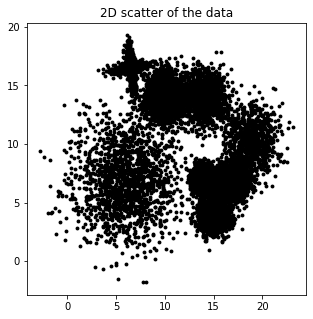

In [4]:
plt.figure(figsize = (5, 5))
plt.title('2D scatter of the data')
plt.scatter(X[:,0],X[:,1],s=15.,alpha=1.0,c='black',linewidths=0.0)
plt.show()

In [5]:
# initialise the Data class
data = Data(X)


In [6]:
# compute distances up to the maxk NN
data.compute_distances(maxk = 1000)

In [7]:
data.maxk

1000

In [8]:
# estimate ID
data.compute_id_2NN()

(2.0138881045367265, 0.0, 0.06604661885682919)

In [9]:
data.compute_density_kstarNN()

(array([-2.5 , -7.2 , -8.55, ..., -1.75, -5.8 , -6.42]),
 array([0.08, 0.17, 0.17, ..., 0.06, 0.07, 0.07]))

In [10]:
# estimate density with PAk using cython implementation of Newton-Raphson minimisation
# data.compute_density_PAk()

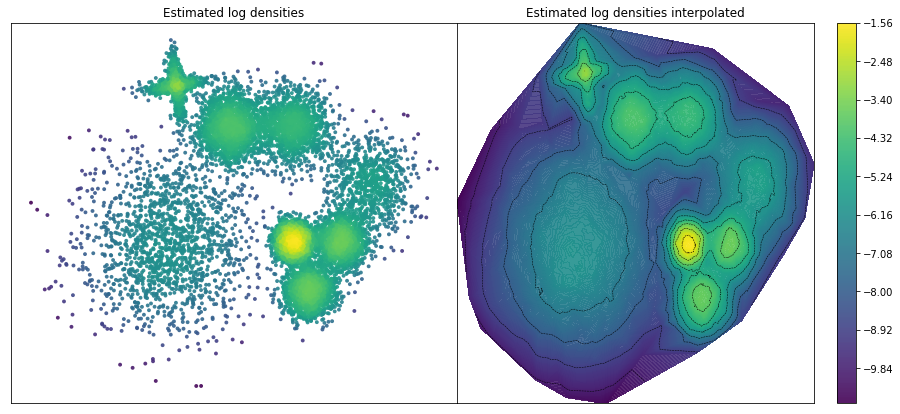

In [11]:
f, [ax1 ,ax2] = plt.subplots(1, 2, figsize = (16, 7),gridspec_kw={'hspace': 0.05, 'wspace': 0})
ax1.yaxis.set_major_locator(plt.NullLocator())
ax1.xaxis.set_major_locator(plt.NullLocator())
ax1.set_title('Estimated log densities')

ax1.scatter(X[:,0],X[:,1],s=15.,alpha=0.9, c = data.log_den,linewidths=0.0)
ax2.yaxis.set_major_locator(plt.NullLocator())
ax2.xaxis.set_major_locator(plt.NullLocator())
ax2.set_title('Estimated log densities interpolated')
ax2.tricontour(X[:,0],X[:,1],data.log_den,levels=10, linewidths=0.5, colors='k')
fig2=ax2.tricontourf(X[:,0],X[:,1],data.log_den,levels=250,alpha=0.9)

plt.colorbar(fig2)
plt.show()

## Advanced DP clustering

In [12]:
# estimate clusters
data.compute_clustering_ADP(Z = 1.65, halo=True)

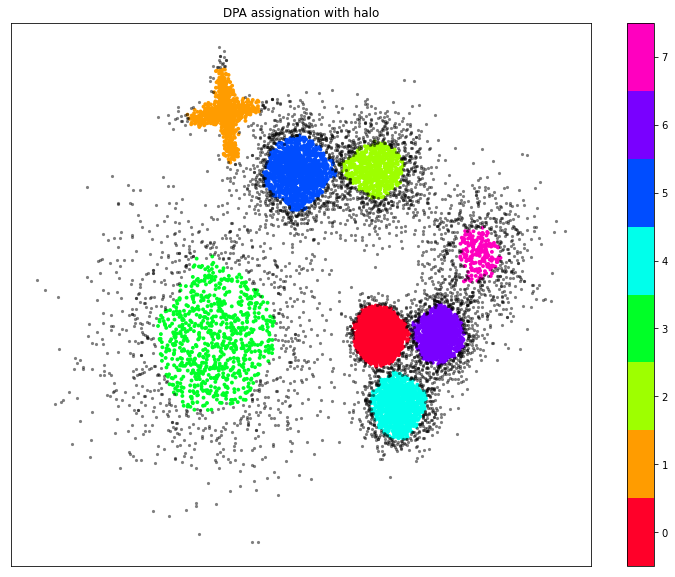

In [13]:

Nclus_m=len(data.cluster_centers) 
cmap = plt.get_cmap('gist_rainbow', Nclus_m)
f, ax = plt.subplots(1, 1, figsize = (13, 10))
ax.yaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_locator(plt.NullLocator())
ax.set_title('DPA assignation with halo')
xdtmp=[]
ydtmp=[]
ldtmp=[]
xntmp=[]
yntmp=[]
for j in range(len(data.cluster_assignment)):
    if (data.cluster_assignment[j]!=-1):
        xdtmp.append(data.X[j,0]) 
        ydtmp.append(data.X[j,1])
        ldtmp.append(data.cluster_assignment[j])
    else:
        xntmp.append(data.X[j,0])
        yntmp.append(data.X[j,1])
        
plt.scatter(xdtmp,ydtmp,s=15.,alpha=1.0, c=ldtmp,linewidths=0.0,cmap=cmap)
plt.colorbar(ticks=range(Nclus_m))
plt.clim(-0.5, Nclus_m-0.5)
plt.scatter(xntmp,yntmp,s=10.,alpha=0.5, c='black',linewidths=0.0)
plt.show()

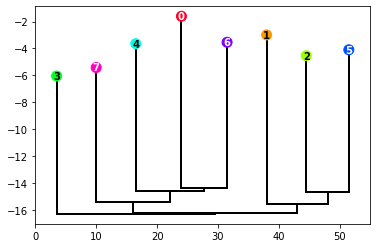

In [14]:
get_dendrogram(data,cmap="gist_rainbow")

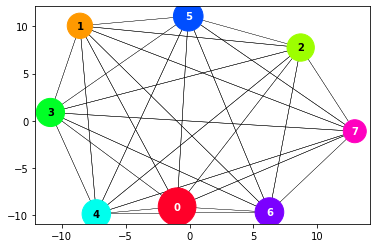

In [15]:
# plot graph of clusters
plot_MDS(data,cmap='gist_rainbow')

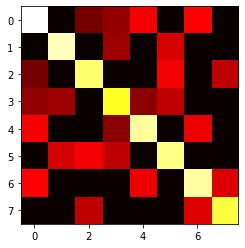

In [16]:
# plot connectivity matrix
plot_matrix(data)


## Classical DP clustering

In [17]:
data.compute_DecGraph()

Number of points for which self.delta needed call to cdist= 6


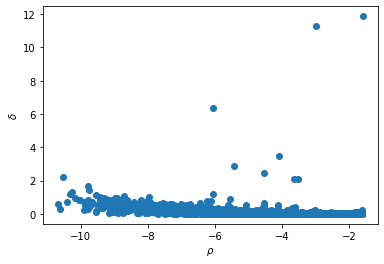

In [18]:
plot_DecGraph(data)

In [19]:
data.compute_clustering_DP(dens_cut=-7,delta_cut=1.75, halo=True)

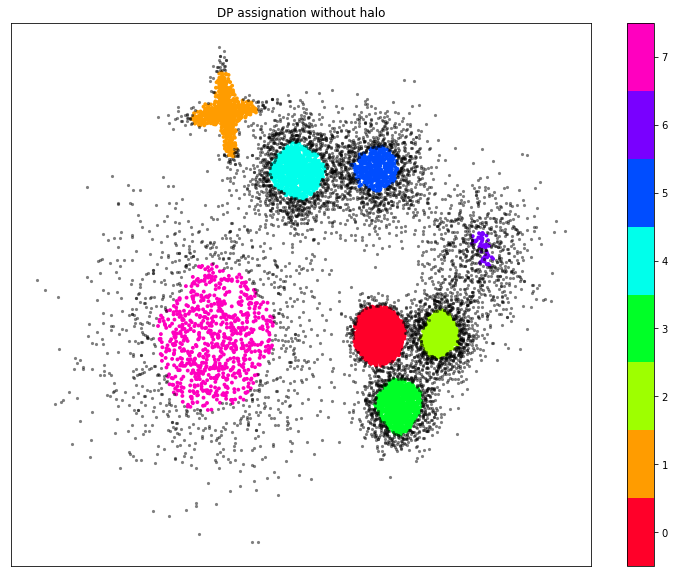

In [20]:
Nclus_m=np.max(data.cluster_assignment)+1
color= plt.get_cmap('gist_rainbow', Nclus_m)
f, ax = plt.subplots(1, 1, figsize = (13, 10))
ax.yaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_locator(plt.NullLocator())
ax.set_title('DP assignation without halo')
xdtmp=[]
ydtmp=[]
ldtmp=[]
xntmp=[]
yntmp=[]
for j in range(len(data.cluster_assignment)):
    if (data.cluster_assignment[j]!=-1):
        xdtmp.append(data.X[j,0]) 
        ydtmp.append(data.X[j,1])
        ldtmp.append(data.cluster_assignment[j])
    else:
        xntmp.append(data.X[j,0])
        yntmp.append(data.X[j,1])
        
plt.scatter(xdtmp,ydtmp,s=15.,alpha=1.0, c=ldtmp,linewidths=0.0,cmap=color)
plt.colorbar(ticks=range(Nclus_m))
plt.clim(-0.5, Nclus_m-0.5)
plt.scatter(xntmp,yntmp,s=10.,alpha=0.5, c='black',linewidths=0.0)
plt.show()